# APIs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from joblib import Memory
import preprocessing_utils
import umap
import umap.plot
import plotly.express as px
from sklearn.cluster import HDBSCAN
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

2025-05-08 19:37:20.130664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/lib

In [12]:
cache_dir = './cache'
memory = Memory(location=cache_dir, verbose=0)

# Setup Data

import training data from .csv file

In [3]:
data = pd.read_csv('data/train.csv')
data.shape

(10189, 2)

import test data - problems for which the category is to be predicted

In [4]:
test_data = pd.read_csv('data/test.csv')
test_data.head()

,id,Question
0,0,b'Solve 0 = -i - 91*i - 1598*i - 64220 for i.\n'
1,1,Galperin G.A.\n\nA natural number $N$ is 999.....
2,2,Example 7 Calculate $\frac{1}{2 \sqrt{1}+\sqrt...
3,3,"If $A$, $B$, and $C$ represent three distinct ..."
4,4,2. Calculate $1+12+123+1234+12345+123456+12345...


In [5]:
test_data.shape

(3044, 2)

# Training data exploration

In [6]:
data.head()

,Question,label
0,A solitaire game is played as follows. Six di...,3
1,2. The school table tennis championship was he...,5
2,"Given that $x, y,$ and $z$ are real numbers th...",0
3,$25 \cdot 22$ Given three distinct points $P\l...,1
4,I am thinking of a five-digit number composed ...,5


check for missing values

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10189 entries, 0 to 10188
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  10189 non-null  object
 1   label     10189 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.3+ KB


Total samples for each class label

In [8]:
np.bincount(data.label)

array([2618, 2439, 1039,  368, 1712, 1827,  100,   86])

Classes 3, 6, and 7 have comparatively very low representation.

In [9]:
category = ['Algebra', 'Geometry', 'Calculus', 'Statistics', 'Number_theory', 'Combinatorics', 'Linear_Algebra', 'Abstract_Algebra']

## Creating train and test sets

In [117]:
text_train, text_test, y_train, y_test = train_test_split(np.array(data['Question']), np.array(data['label']), 
                                                          random_state=0, stratify=data['label'])

# Bag of Words

In [ ]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(f'X_train: {repr(X_train)}')

X_train: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 189663 stored elements and shape (7641, 11213)>


Analyzing tokens

In [37]:
feature_names = vect.get_feature_names_out()
print(f'First 50 features:\n{feature_names[:200]}')

First 50 features:
['00' '000' '00000000' '000001' '0001' '00010000' '001' '0013' '002'
 '00214' '0025' '0026' '0028' '003' '004' '005' '006' '007' '008' '009'
 '01' '0101' '010512' '011' '011011' '011016' '012' '0123432123432' '013'
 '014' '017' '018' '019' '0197' '02' '020' '020922' '024' '025' '026'
 '027' '028' '03' '030' '030511' '030521' '030922' '031' '033' '03375'
 '035' '036' '039' '04' '040' '040914' '041214' '041224' '044' '045' '046'
 '049' '05' '050' '050936' '051' '052' '053' '056' '058' '05in' '06'
 '060723' '061021' '061045' '062' '0629' '063' '067' '068' '06inch' '07'
 '070' '070614' '071241' '071243' '076' '077' '0784' '0793' '08' '081224'
 '081244' '082' '084' '085' '088' '09' '090734' '090812' '091212' '092'
 '093' '095' '097' '098' '0_' '0_7' '0th'
 '0uucogtryj4ymjphfsk3oqihrqfut7usgclcbgasyhq' '10' '100' '1000' '10000'
 '100000' '1000000' '1000000000' '10000x' '10001' '100010001' '10003'
 '1000th' '1000x' '1001' '1001_b' '1001x' '1002' '10032' '1004' '1005'
 '1006

Since the dataset is of math problem statements, lot of tokens are just going to numbers or alphanumeric strings. Since these will be common across math problems, at first thought, they won't provide any value in differentiating between problem categories and should be excluded.

In [40]:
print(f'\nEvery 25th feature:\n{feature_names[::25]}')


Every 25th feature:
['00' '011016' '035' '062' '091212' '1001x' '1014' '1059' '10cm'
 '1111111111111111' '1153' '11y' '12199' '1238' '1275' '1300' '1350'
 '13970' '1434' '1481' '1510' '1565' '1616' '17005' '1792' '186' '1918'
 '1959' '198' '1997' '1尺' '2009x' '2020x'
 '2024_04_17_fd2d0ad36e2f3d54c0ceg' '2024_05_06_2befe970655743580344g'
 '2024_05_08_22585010b2534c7ab9ebg' '2025' '208' '211976' '221213'
 '231021' '23_b' '247' '2521' '260914' '273' '281012' '2925' '2bf' '2pq'
 '2y_2' '3032' '314' '325' '333x' '3452' '35th' '36th' '3808' '394' '3c'
 '4000' '40845' '421' '437' '4492' '4641' '481' '49560' '4l' '502' '51242'
 '53' '5490' '57' '5_b' '603' '630' '645' '66' '685' '6z' '725' '753'
 '784' '7x' '8192' '83x' '874' '8em' '9218' '955' '99' '9n' 'a8' 'a_7x'
 'ab_0c_0' 'about' 'accompany' 'acquainted' 'adding' 'aec' 'again'
 'aimeville' 'alexandru' 'alloy' 'alёna' 'an' 'angles' 'answered' 'apb'
 'applies' 'arc' 'armies' 'articles' 'assembled' 'asterisk' 'attempt'
 'automates' 'axial' 

From these, most tokens seem like subjects/nouns used to describe a problem statement.
I can also see some tokens denoting shapes, measures, concepts which will be useful in identifying the category.

In [42]:
print(f'Last 250 features:\n{feature_names[-250:]}')

Last 250 features:
['xz' 'xzcdqhggkfi' 'xzp0cepacei' 'y62' 'y_' 'y_0' 'y_1' 'y_2' 'y_3' 'y_4'
 'y_5' 'y_a' 'y_i' 'y_k' 'y_n' 'y_p' 'y_s' 'yann' 'yaoyao' 'yaps' 'yard'
 'yarn' 'yasmine' 'yatsenko' 'yaxis' 'yb' 'ybottom' 'year' 'years'
 'yellow' 'yequals' 'yes' 'yesterday' 'yet' 'yf_y' 'yi' 'yield' 'yielding'
 'yields' 'yingchun' 'yingying' 'ylimits' 'ymax' 'ymin' 'yndira' 'yolki'
 'york' 'you' 'young' 'younger' 'youngest' 'your' 'yourself' 'youth'
 'yscale' 'ystep' 'yt' 'ytop' 'yu' 'yuan' 'yugoslav' 'yuliawan' 'yuri'
 'yw'
 'yxr0ywnobwvudhmvoc8zl2iwzjnjmdaxnwewmtc1zgnjmtkwzmzlzmjlmgrlogrhyjk4nzczlnbuzw'
 'yy' 'yz' 'z_' 'z_0' 'z_1' 'z_2' 'z_3' 'z_4' 'z_j' 'z_jz_k' 'z_k' 'z_n'
 'za' 'zadaci' 'zadane' 'zadatak' 'zahl' 'zahlen' 'zahlenmäßig'
 'zalakomár' 'zanfirica' 'započne' 'zatvara' 'završava' 'završi' 'zebra'
 'zero' 'zeroes' 'zeros' 'zf' 'zhai' 'zhang' 'zhao' 'zhejiang' 'zhenhua'
 'zhenping' 'zhenya' 'zhouf' 'zigzag' 'zinc' 'zmey' 'znayka' 'zo' 'zoe'
 'zoka' 'zomr' 'zone' 'zoranel' 'zr

Finally, some tokens like 'yxr0ywnobwvudhmvoc8zl2iwzjnjmdaxnwewmtc1zgnjmtkwzmzlzmjlmgrlogrhyjk4nzczlnbuzw' may have been created as a result of Vectorization, and may appear only once. We also have some tokens which appear to be in Russian and Chinese. I will ignore them for now.

In [72]:
sel_rows = np.where(
    X_train[:, vect.vocabulary_.get("yxr0ywnobwvudhmvoc8zl2iwzjnjmdaxnwewmtc1zgnjmtkwzmzlzmjlmgrlogrhyjk4nzczlnbuzw")].toarray().ravel()>0)
text_train[sel_rows]

array(['In the diagram below, $BP$ bisects $\\angle ABC$, $CP$ bisects $\\angle BCA$, and $PQ$ is perpendicular to $BC$. If $BQ\\cdot QC=2PQ^2$, prove that $AB+AC=3BC$.\n[img]https://services.artofproblemsolving.com/download.php?id=YXR0YWNobWVudHMvOC8zL2IwZjNjMDAxNWEwMTc1ZGNjMTkwZmZlZmJlMGRlOGRhYjk4NzczLnBuZw==&rn=VlRSTUMgMjAwNi5wbmc=[/img]'],
      dtype=object)

# Baseline Model

## Logistic Regression

In [ ]:
pipe = make_pipeline(CountVectorizer(),
                     LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
strat_cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro', n_jobs=-1)
grid.fit(text_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]},
             scoring='f1_micro')

In [82]:
print(f'Best cross-validation score (f1-micro): {grid.best_score_:.3f}')

Best cross-validation score (f1-micro): 0.769


The baseline CV score is 77%.

In [89]:
y_pred = grid.best_estimator_.predict(text_train)
print(f'Classification report:\n{classification_report(y_train, y_pred, digits=3)}')

Classification report:
              precision    recall  f1-score   support

           0      0.841     0.930     0.883      1963
           1      0.965     0.955     0.960      1829
           2      0.854     0.797     0.825       779
           3      0.984     0.906     0.943       276
           4      0.865     0.889     0.877      1284
           5      0.937     0.872     0.903      1370
           6      1.000     0.347     0.515        75
           7      0.912     0.800     0.852        65

    accuracy                          0.898      7641
   macro avg      0.920     0.812     0.845      7641
weighted avg      0.900     0.898     0.896      7641



There seems to be a good balance between precision and recall for all the classes except 'class 6'. 
For Class 6, there are 0 FP but high FN - predicting samples from Class 6 as other class. 

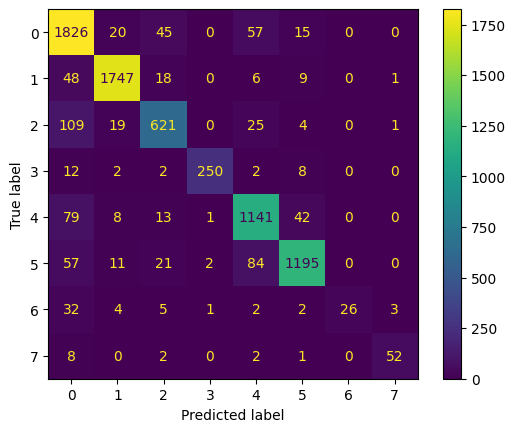

In [103]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

In [117]:
print(f'ROC AUC score: {roc_auc_score(y_train, grid.best_estimator_.predict_proba(text_train), multi_class='ovr', average='micro'):.3f}')

ROC AUC score: 0.992


## Naive Bayes - Multinomial

In [ ]:
pipe = make_pipeline(CountVectorizer(),
                     MultinomialNB())
param_grid = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
strat_cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro', n_jobs=-1)
grid.fit(text_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10,
                                                  100]},
             scoring='f1_micro')

In [133]:
print(f'Best CV score: {grid.best_score_:.3f}')

Best CV score: 0.725


Naive Bayes performed significantly worse than Logistic Regression. Since the score is 72.5%, it may improve with large training data.

In [134]:
print(f'ROC AUC score for Naive Bayes: {
    roc_auc_score(y_train, grid.best_estimator_.predict_proba(text_train), multi_class='ovr', average='micro'):.3f}')

ROC AUC score for Naive Bayes: 0.967


# Analysing min_df

As we know, certain tokens (numbers and alphanumeric) will be specific to a particular problem. That is why it is better to drop them.

In [129]:
text_train.shape

(7641,)

In [132]:
for i in range(1, 8):
    vect = CountVectorizer(min_df=i).fit(text_train)
    X_train = vect.transform(text_train)
    print(f'For min_df={i}: {repr(X_train)}\n')

For min_df=1: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 189663 stored elements and shape (7641, 11213)>

For min_df=2: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 183884 stored elements and shape (7641, 5434)>

For min_df=3: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 180856 stored elements and shape (7641, 3920)>

For min_df=4: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 178636 stored elements and shape (7641, 3180)>

For min_df=5: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 176748 stored elements and shape (7641, 2708)>

For min_df=6: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 175128 stored elements and shape (7641, 2384)>

For min_df=7: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 173562 stored elements and shape (7641, 2123)>



In [ ]:
param_grid = {'countvectorizer__min_df': [2, 3, 7],
    'logisticregression__C': [0.01, 0.1, 1, 10]}
pipe = make_pipeline(CountVectorizer(),
                     LogisticRegression(max_iter=1000))
strat_cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro', n_jobs=-1)
grid.fit(text_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'countvectorizer__min_df': [2, 3, 7],
                         'logisticregression__C': [0.01, 0.1, 1, 10]},
             scoring='f1_micro')

In [136]:
print(f'Best CV score: {grid.best_score_:.3f}')

Best CV score: 0.770


With min_df = 3 as well, we are able to get the same score of 77% that was received with default min_df.

This reduces the feature count drastically to 3920 from 11213.

## Analyze selected features at min_df = 3

In [138]:
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names_out()

In [142]:
print(f'Every 10th feature:\n{feature_names[::10]}')

Every 10th feature:
['00' '05' '1000th' '1023' '10a' '115' '1200' '128' '134' '143' '14x'
 '157' '169' '18' '19' '1964' '1980' '199' '1999' '2002' '2011' '202'
 '2024_04_20_e85ef69091c57cb633f3g' '212' '221' '234' '246' '260' '282'
 '297' '2h' '2x' '303' '315' '329' '340' '357' '374' '39' '3x_i' '406'
 '434' '456' '4b' '501' '518' '56' '5b' '615' '672' '7000' '74' '79' '820'
 '8cm' '96' '997' 'a5' 'a_4' 'a_n' 'able' 'accomplish' 'across' 'added'
 'advance' 'age' 'ak' 'aligned' 'already' 'am' 'and' 'annual' 'aob'
 'appeared' 'appropriate' 'arccos' 'argument' 'arrival' 'as' 'assume'
 'attack' 'awarded' 'b4' 'bad' 'banks' 'batch' 'became' 'begins' 'bernd'
 'big' 'birds' 'blocks' 'boldsymbol' 'bottles' 'boy' 'breakfast' 'built'
 'buys' 'cad' 'call' 'candy' 'cards' 'cat' 'cccc' 'ceil' 'centre' 'chain'
 'characters' 'chickens' 'choices' 'circle' 'city' 'climb' 'clubs'
 'coincides' 'color' 'com' 'common' 'competing' 'composite' 'conditions'
 'connected' 'consisting' 'contained' 'continue' 'co

This shows that a lot of the garbage tokens have been removed. However, around 600 of the tokens are still numbers.

In [148]:
y_pred = grid.best_estimator_.predict(text_train)
print(f'f1_score: {f1_score(y_train, y_pred, average='micro'):.3f}')

f1_score: 0.889


## Looking at Model Coefficients

In [187]:
def plot_model_coefficients(grid, vect, model, features_count):
    coef = grid.best_estimator_.named_steps[model].coef_
    class_labels = grid.best_estimator_.named_steps[model].classes_
    feature_names = grid.best_estimator_.named_steps[vect].get_feature_names_out()
    n_cols = 2
    n_rows = int(np.ceil(len(class_labels)/n_cols))

    plt.style.use('ggplot')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows*3))
    axes = axes.flatten()
    
    for i, label in enumerate(class_labels):
        top_idx = np.argsort(coef[i])[-features_count:]
        axes[i].bar(range(features_count), coef[i][top_idx], color='seagreen')
        axes[i].set_xticks(range(features_count)) 
        axes[i].set_xticklabels(feature_names[top_idx], rotation=60, ha='right', fontsize=9)
        axes[i].set_title(f'Class {label} - {category[i]}', fontsize=10)
    
    fig.suptitle(f'{model} - Top {features_count} features by coefficient', fontsize=14)
    plt.tight_layout()    

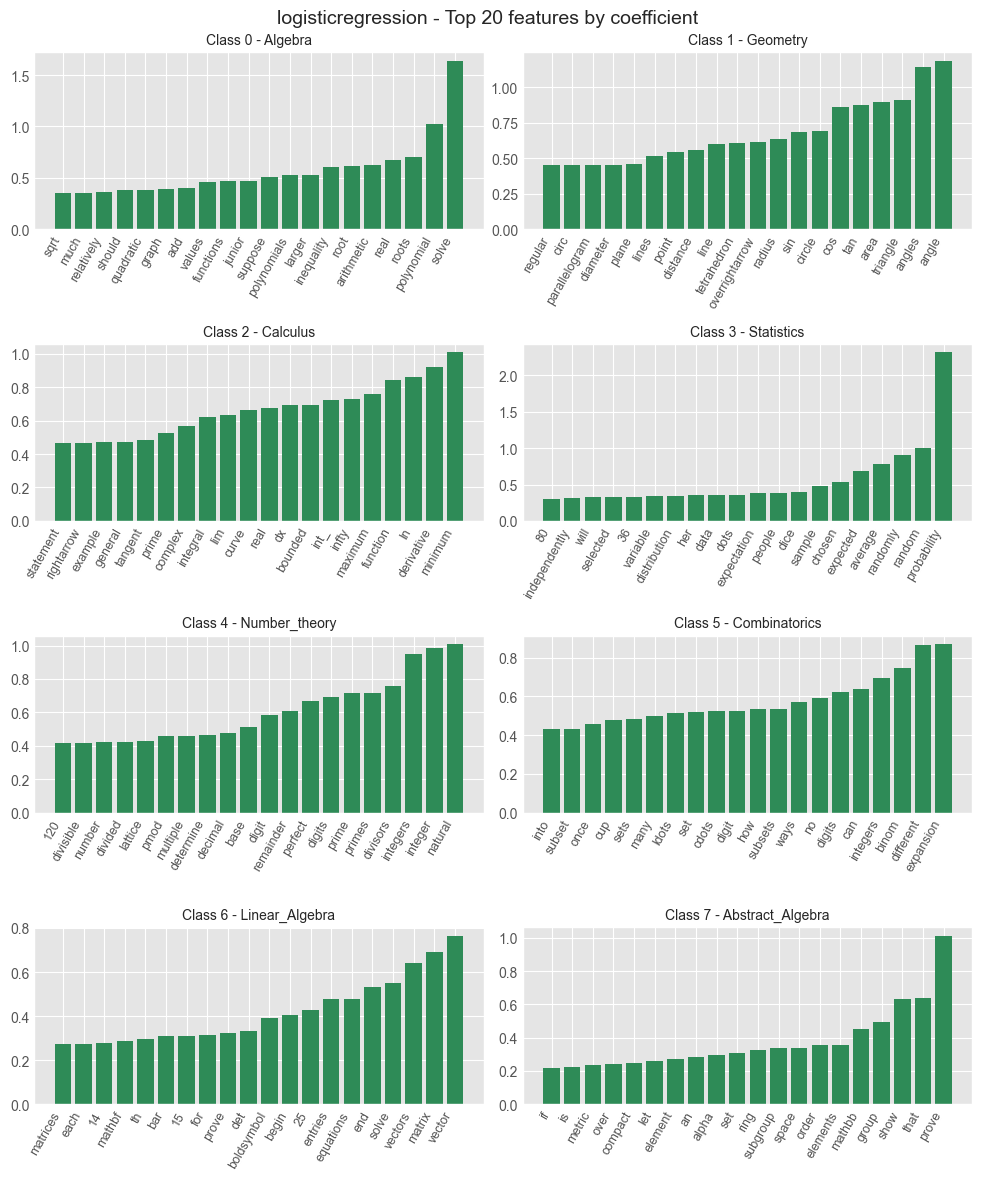

In [189]:
plot_model_coefficients(grid, 'countvectorizer', 'logisticregression', 20)

As one would expect, the features with highest coefficients are mathematical terms and seem likely predictors for corresponding classes.

for Linear Algebra, feature 25 seems unnatural. Let's check the samples.

In [228]:
vect = grid.best_estimator_.named_steps['countvectorizer']
X_train = vect.transform(text_train)
sel_rows = np.where(X_train[:, vect.vocabulary_.get('25')].toarray().ravel())[0]
text_train[sel_rows[:5]]

array(['Triangle $AB_0C_0$ has side lengths $AB_0 = 12$ , $B_0C_0 = 17$ , and $C_0A = 25$ . For each positive integer $n$ , points $B_n$ and $C_n$ are located on $\\overline{AB_{n-1}}$ and $\\overline{AC_{n-1}}$ , respectively, creating three similar triangles $\\triangle AB_nC_n \\sim \\triangle B_{n-1}C_nC_{n-1} \\sim \\triangle AB_{n-1}C_{n-1}$ . The area of the union of all triangles $B_{n-1}C_nB_n$ for $n\\geq1$ can be expressed as $\\tfrac pq$ , where $p$ and $q$ are relatively prime positive integers. Find $q$ .',
       'Sides $AB,~ BC$, and $CD$ of (simple*) quadrilateral $ABCD$ have lengths $4,~ 5$, and $20$, respectively. \nIf vertex angles $B$ and $C$ are obtuse and $\\sin C = - \\cos B =\\frac{3}{5}$, then side $AD$ has length\n\nA polygon is called “simple” if it is not self intersecting.\n$\\textbf{(A) }24\\qquad \\textbf{(B) }24.5\\qquad \\textbf{(C) }24.6\\qquad \\textbf{(D) }24.8\\qquad \\textbf{(E) }25$',
       "b'Suppose 0 = -2*d - 4*f, -10*f = -5*d - 25 + 45. Solv

## Top Features influencing Classes

In [244]:
def plot_top_features_influencing_classes(grid, vect, model, top_n=20):
    model = grid.best_estimator_.named_steps[model]
    vect = grid.best_estimator_.named_steps[vect]
    feature_names = vect.get_feature_names_out()
    coef = model.coef_  # shape: (n_classes, n_features)
    class_labels = model.classes_

    max_coef = coef.max(axis=0)
    top_features_idx = np.argsort(max_coef)[-top_n:][::-1]

    data = []
    for idx in top_features_idx:
        feature = feature_names[idx]
        weights = coef[:, idx]
        top_classes_idx = np.argsort(weights)[-3:][::-1]
        influenced_classes = [(category[i], weights[i]) for i in top_classes_idx]
        label_str = ", ".join(f"{c} ({w:.2f})" for c, w in influenced_classes)
        most_influential = category[top_classes_idx[0]]
        data.append((feature, max_coef[idx], label_str, most_influential))

    df = pd.DataFrame(data, columns=["Feature", "Max Coefficient", "Top Classes", "Main Class"])
    
    # Plot
    plt.figure(figsize=(10, top_n * 0.3))
    ax = sns.barplot(data=df, y="Feature", x="Max Coefficient", hue="Main Class", dodge=False, palette="tab10")

    for i, label in enumerate(df["Top Classes"]):
        ax.text(0.1, i, label, va='center', fontsize=8, color='black')

    plt.title(f"Top {top_n} Influential Features and Their Strongest Classes")
    plt.xlabel("Max Coefficient")
    plt.ylabel("Feature")
    plt.legend(title="Most Influenced Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return df

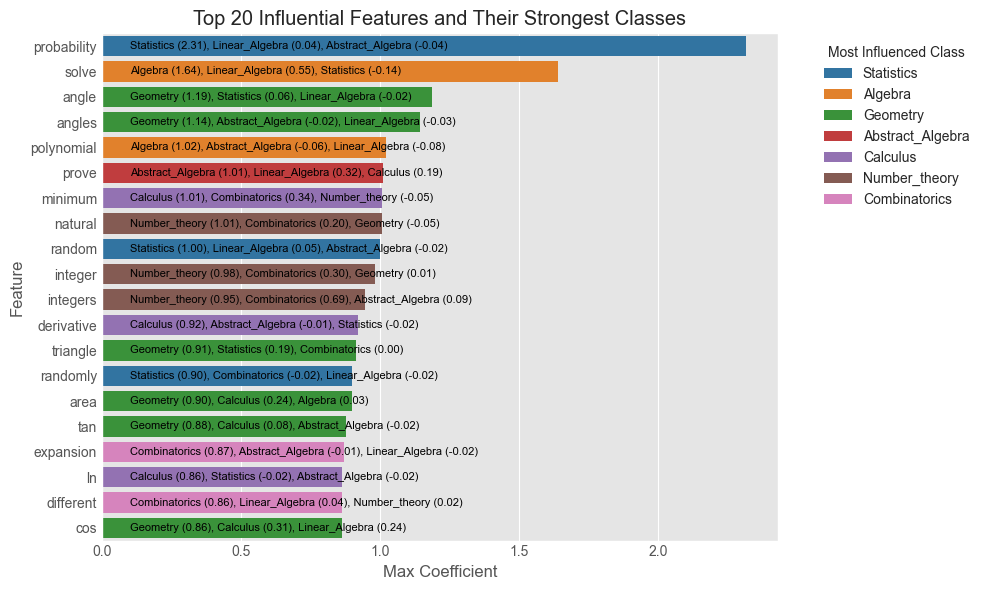

In [246]:
tfic_df = plot_top_features_influencing_classes(grid, 'countvectorizer', 'logisticregression')

It can be seen that certain features have positive influence on multiple classes, and will benefit from including context.

Examples: solve, natural, integer, triangle, area, cos, etc.

# tf-idf

In [ ]:
pipe = make_pipeline(TfidfVectorizer(),
                     LogisticRegression(max_iter=1000))
param_grid = {'tfidfvectorizer__min_df': [1, 2, 3, 5, 7],
              'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
strat_cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro', n_jobs=-1)
grid.fit(text_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'tfidfvectorizer__min_df': [1, 2, 3, 5, 7]},
             scoring='f1_micro')

In [252]:
print(f'Best CV score: {grid.best_score_:.3f}')

Best CV score: 0.775


Model with tf-idf Vectorizer performed only slightly better than CountVectorizer with min_df=3

In [254]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train = vect.transform(text_train)
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = np.argsort(max_value)
feature_names = vect.get_feature_names_out()
print(f"Features with lowest tfidf:\n{feature_names[sorted_by_tfidf[:20]]}")
print(f"\nFeatures with highest tfidf:\n{feature_names[sorted_by_tfidf[-20:]]}")

Features with lowest tfidf:
['possibility' 'absolutely' 'rgb' '14cm' '10cm' 'grow' 'mind' 'petrov'
 '1912' '1366' 'assigning' 'silent' 'standards' 'unrecovered' 'reducing'
 'linetype' 'spoke' 'clip' 'client' 'trading']

Features with highest tfidf:
['frac' 'dot' 'binom' 'h_' 'boldsymbol' 'circ' '2024' 'mu' 'underline'
 'overrightarrow' 'c_' 'm_' 'vec' 'cot' 'z_' 'mathrm' 'a_' 'x_' 'sqrt'
 'factorize']


In [255]:
sorted_by_idf = np.argsort(vect.idf_)
print(f'Features with lowest idf:\n{feature_names[sorted_by_idf[:100]]}')

Features with lowest idf:
['the' 'of' 'is' 'and' 'that' 'in' 'find' 'are' 'for' 'to' 'be' 'number'
 'frac' 'if' 'with' 'all' 'then' 'let' 'numbers' 'on' 'such' 'what' 'two'
 'positive' 'right' 'at' 'value' 'by' 'each' 'left' 'how' 'points' '10'
 'given' 'from' 'integers' 'qquad' 'many' 'one' 'which' 'integer' 'an'
 'it' 'as' 'there' 'can' 'point' 'has' 'real' 'sqrt' 'sum' 'triangle'
 'three' 'where' 'this' 'solve' '12' 'have' 'determine' 'not' 'than' 'any'
 'equation' 'example' 'area' 'angle' 'same' 'line' 'possible' 'first' '20'
 'end' 'times' 'problem' '11' 'prime' 'side' 'equal' 'square' 'other'
 'when' 'text' 'cdots' 'maximum' 'following' 'cdot' 'its' 'set' 'between'
 'length' 'these' 'or' 'begin' 'smallest' 'circle' '15' 'sequence'
 'digits' 'values' 'function']


# Lemmatization

Lemmatizing and also removing numbers

In [11]:
lemmatizer = FunctionTransformer(preprocessing_utils.clean_and_lemmatize, validate=False)

In [ ]:
pipe = Pipeline([
    ('lemmatizer', lemmatizer),
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
], memory=memory)
param_grid = {
    'tfidf__min_df': [2, 3],
    'logreg__C' : [0.01, 0.1, 1, 10]
}
strat_cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro', n_jobs=-1, verbose=2)
grid.fit(text_train, y_train)

In [16]:
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_:.3f}')
vect = grid.best_estimator_.named_steps['tfidf']
X_train = vect.transform(text_train)
print(f'Representation of X_train:\n{repr(X_train)}')

Best parameters: {'logreg__C': 10, 'tfidf__min_df': 2}
Best score: 0.764
Representation of X_train:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 132551 stored elements and shape (7641, 3279)>


With Lemmatizing and Best parameters: {'logreg__C': 10, 'tfidf__min_df': 2}, we are getting Best score: 0.764.
The score is lower than what we achieved without lemmatization (0.775); however, the no. of features has significantly reduced.

X_train: 68310 stored elements and shape (7641, 3279)

# Experimenting with n_grams

Though single word tokens show sensible correlations, it will make more sense to increase word count in tokens to provide more context.

In [77]:
pipe = Pipeline([
    ('lemmatizer', lemmatizer),
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
], memory=memory)
param_grid = {
    'tfidf__min_df': [2, 3],
    'tfidf__ngram_range':[(1,1), (1,2), (1,3), (1,4)],
    'logreg__C' : [0.01, 0.1, 1, 10, 100]
}
strat_cv = StratifiedKFold(n_splits=3)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro', n_jobs=-1, verbose=2)
grid.fit(text_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(memory=Memory(location=./cache\joblib),
                                steps=[('lemmatizer',
                                        FunctionTransformer(func=<function clean_and_lemmatize at 0x0000025081A489A0>)),
                                       ('tfidf', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1, 10, 100],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]},
             scoring='f1_micro', verbose=2)

In [79]:
results = pd.DataFrame(grid.cv_results_)
# results = results.sort_values(by=['param_tfidf__min_df', 'param_ridge__alpha', 'param_tfidf__ngram_range'])

In [80]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# axes = axes.flatten()

# for min_df, ax in zip(param_grid['tfidf__min_df'], axes):
#     df_plot = results[results['param_tfidf__min_df']==min_df]
#     df_pivot = df_plot.pivot(index= 'param_ridge__alpha',
#                              columns= 'param_tfidf__ngram_range',
#                              values= 'mean_test_score')
#     sns.heatmap(df_pivot, annot=True, fmt='.3f', cmap='Blues', ax=ax, linewidths=0.5)
#     ax.set_title(f'min_df={min_df}')
#     ax.set_xlabel('tfidf__ngram_range')
#     ax.set_ylabel('ridge__alpha')

# plt.tight_layout()

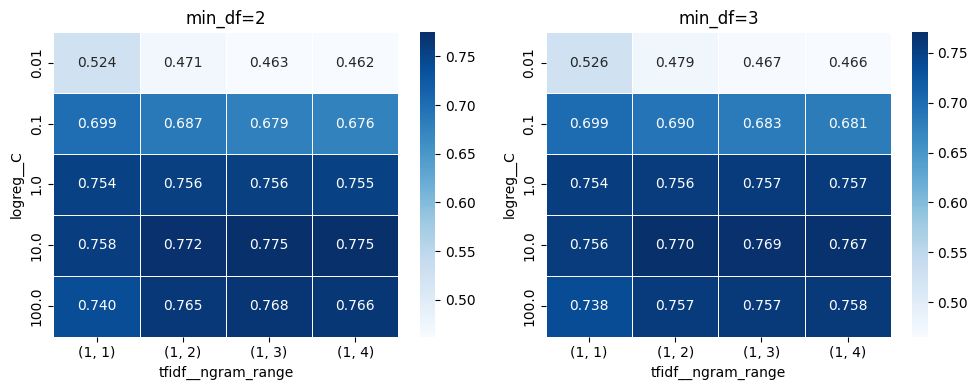

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

for min_df, ax in zip(param_grid['tfidf__min_df'], axes):
    df_plot = results[results['param_tfidf__min_df']==min_df]
    df_pivot = df_plot.pivot(index= 'param_logreg__C',
                             columns= 'param_tfidf__ngram_range',
                             values= 'mean_test_score')
    sns.heatmap(df_pivot, annot=True, fmt='.3f', cmap='Blues', ax=ax, linewidths=0.5)
    ax.set_title(f'min_df={min_df}')
    ax.set_xlabel('tfidf__ngram_range')
    ax.set_ylabel('logreg__C')

plt.tight_layout()

In [81]:
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_:.3f}')
vect = grid.best_estimator_.named_steps['tfidf']
X_train = vect.transform(text_train)
print(f'Representation of X_train:\n{repr(X_train)}')

Best parameters: {'logreg__C': 10, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 4)}
Best score: 0.775
Representation of X_train:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 176328 stored elements and shape (7641, 33026)>


As suspected, increasing the word count in the tokens resulted in better performance, though not a significant increase.

Best parameters: {'logreg__C': 10, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Best score: 0.775
Representation of X_train: 171343 stored elements and shape (7641, 26749)

Increasing the ngram_range greater than (1, 3) resulted in decreasing performance. 

Similar trend for increasing alpha. For alpha=100, the best score was 0.637.


In [61]:
print(f'Test score: {grid.best_estimator_.score(text_test, y_test):.3f}')

Test score: 0.811


In [76]:
print(f'Sparsity of X_train: {1 - np.count_nonzero(X_train.toarray())/np.size(X_train.toarray()):.3f}')

Sparsity of X_train: 0.999


# Unsupervised Techniques

## UMAP

In [55]:
pipe = Pipeline([
    ('lemmatizer', lemmatizer),
    ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3)))
], memory=memory)
pipe.fit(text_train)
X_train = pipe.transform(text_train)

In [56]:
X_train.shape

(7641, 26748)

In [57]:
def draw_umap(data, target, n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', ax=None):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        n_jobs=-1
    )
    u = fit.fit_transform(data)

    if n_components == 2:
        if ax == None:
            ax = plt.gca()
        ax.scatter(u[:, 0], u[:, 1], c=target, cmap='Spectral', s=3)
    if n_components == 3:
        df_umap = pd.DataFrame(u, columns=['UMAP1', 'UMAP2', 'UMAP3'])
        df_umap['label'] = target
        
        fig = px.scatter_3d(
            df_umap, x='UMAP1', y='UMAP2', z='UMAP3',
            color='label',
            opacity=0.7,
            title='3D UMAP projection'
        )
        fig.show()

c:\Users\akuka\OneDrive\Documents\Projects\classifying_math_prob_nlp\nlp-math-prob\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\akuka\OneDrive\Documents\Projects\classifying_math_prob_nlp\nlp-math-prob\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\akuka\OneDrive\Documents\Projects\classifying_math_prob_nlp\nlp-math-prob\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\akuka\OneDrive\Documents\Projects\classifying_math_prob_nlp\nlp-math-prob\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed i

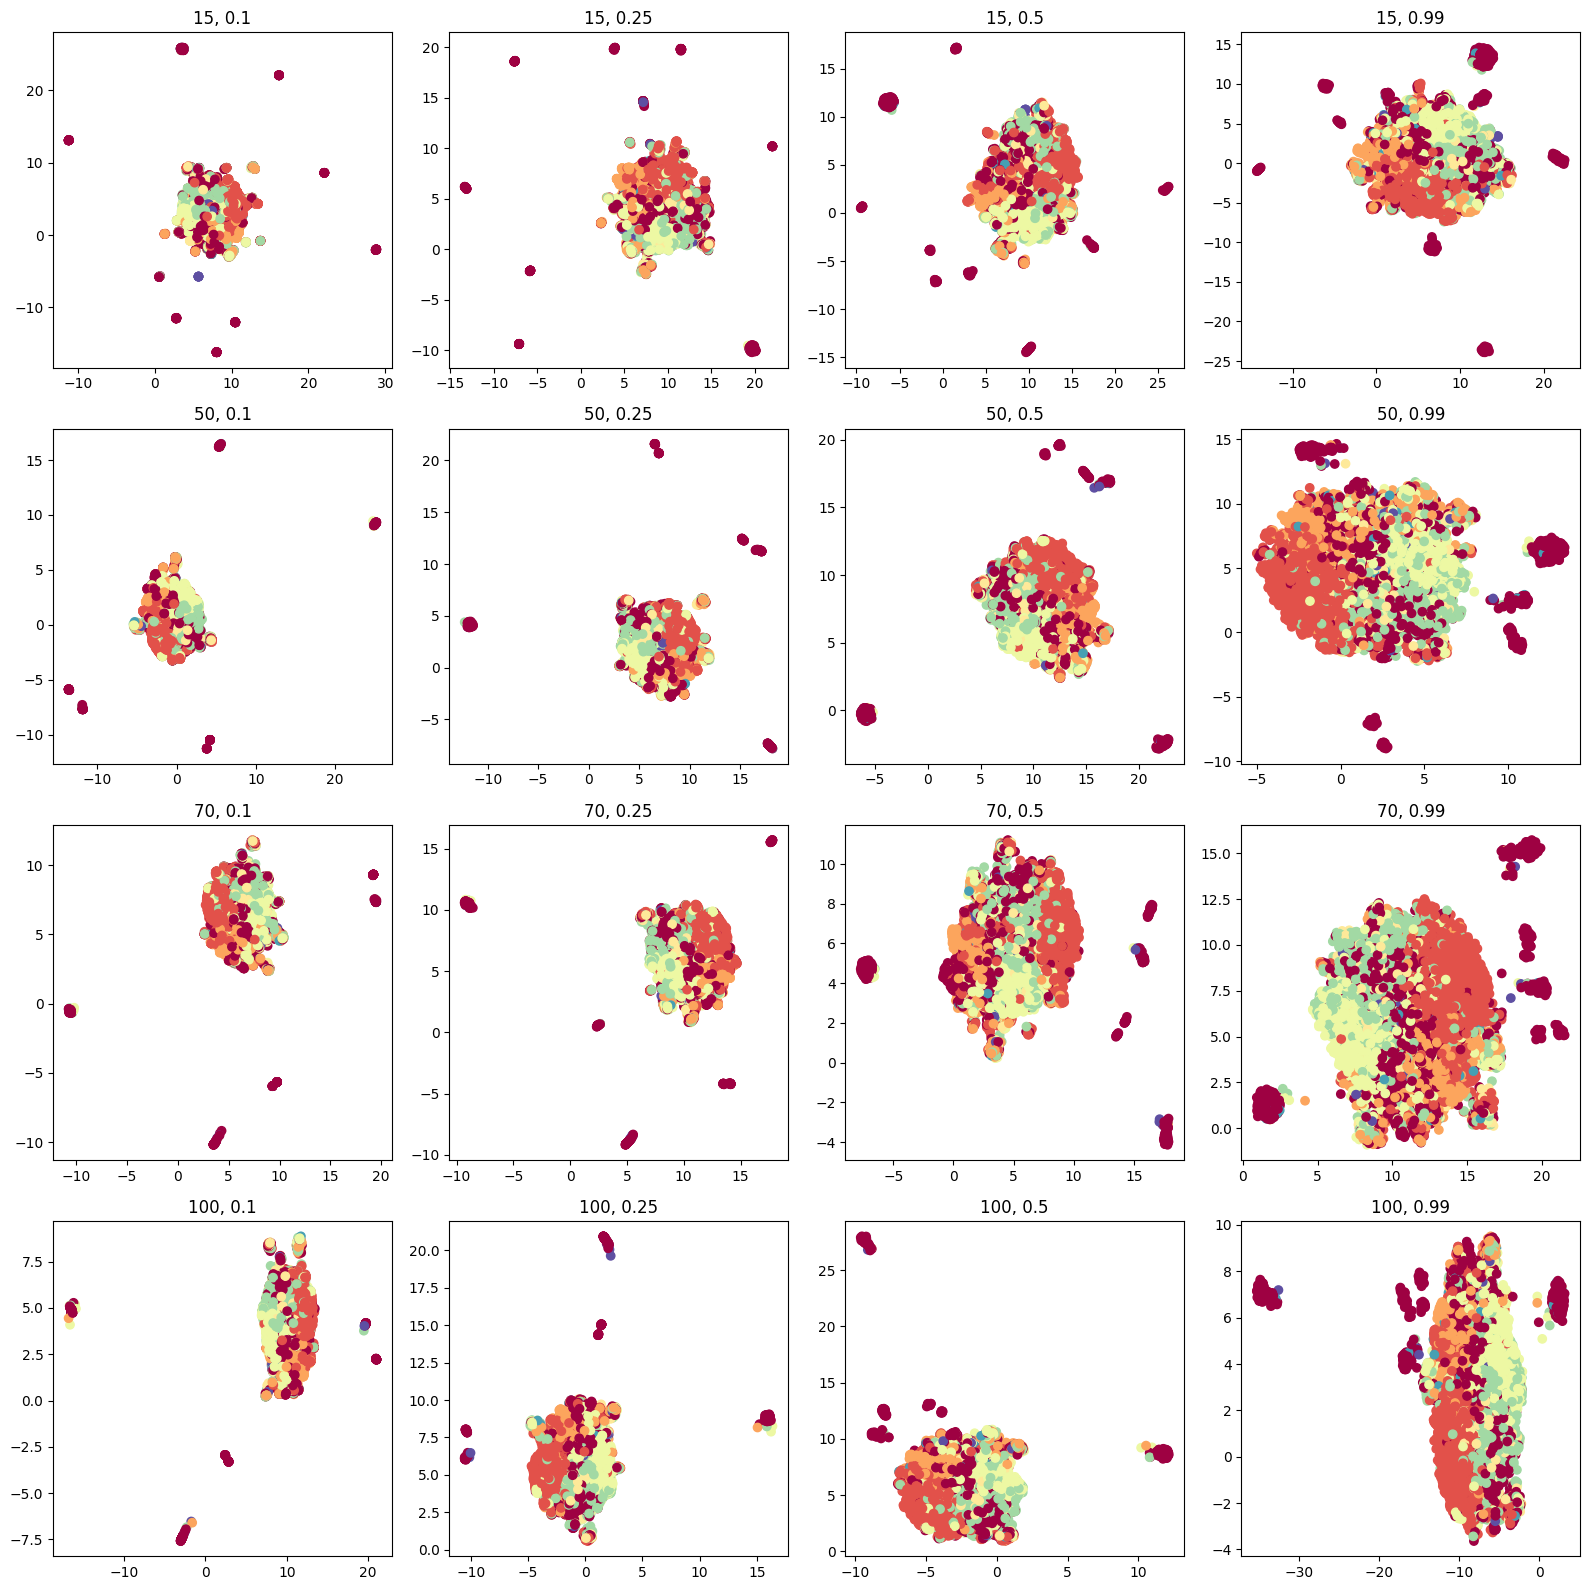

In [ ]:
param_grid = {
    'n_neighbors': [15, 50, 70, 100],
    'min_dist': [0.1, 0.25, 0.5, 0.99]
}

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()
i = 0
for n_neighbor in param_grid['n_neighbors']:
    for dist in param_grid['min_dist']:
        draw_umap(X_train, y_train, n_neighbors=n_neighbor, min_dist=dist, ax=axes[i])
        axes[i].set_title(f'{n_neighbor}, {dist}')
        i += 1
plt.tight_layout()

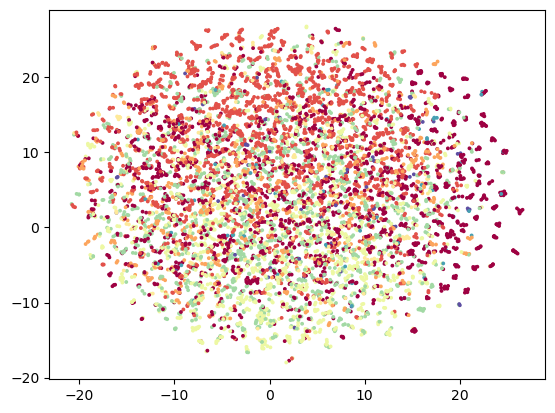

In [67]:
draw_umap(X_train, y_train, n_neighbors=2, min_dist=1, metric='cosine', n_components=2)

UMAP fit

In [70]:
fit = umap.UMAP(
    n_neighbors=2,
    min_dist=1,
    n_components=2,
    metric='cosine',
    n_jobs=-1
)
u = fit.fit_transform(X_train)

## HDBSCAN

HDBSCAN fit

/tmp/ipykernel_6171/93394531.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


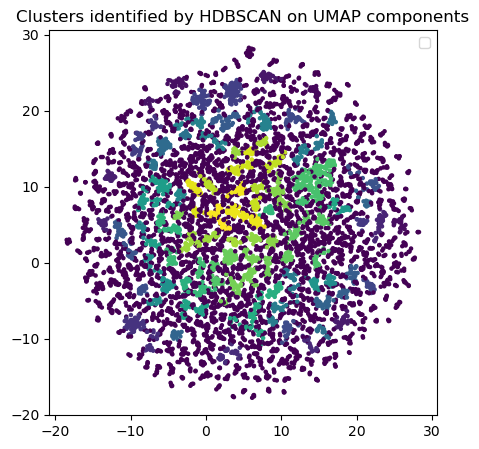

In [82]:
hdb = HDBSCAN(min_cluster_size=15)
hdb.fit(u)
plt.figure(figsize=(5, 5))
plt.scatter(u[:, 0], u[:, 1], c=hdb.labels_, s=5)
plt.title('Clusters identified by HDBSCAN on UMAP components')
plt.legend()

Since the points are too close, it is difficult for the model to differentiate the labels.

Checking the score:

In [83]:
y_pred = hdb.labels_
print(np.unique(y_pred))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94
 95]


## Truncated SVD

In [84]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(X_train)

TruncatedSVD(n_iter=7, random_state=42)

In [85]:
print(f'Explained Variance: {svd.explained_variance_ratio_.sum()*100:.2f} %')

Explained Variance: 3.65 %


In [86]:
X_svd = svd.transform(X_train)
X_svd.shape 

(7641, 2)

Text(0.5, 1.0, 'Truncated SVD transformation on X_train')

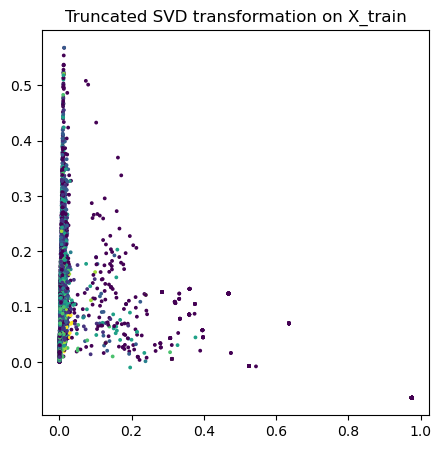

In [87]:
plt.figure(figsize=(5, 5))
plt.scatter(X_svd[:, 0], X_svd[:, 1], s=3, c=y_train)
plt.title('Truncated SVD transformation on X_train')

At n_components=2, a classifier won't be able to do a good job.

In [109]:
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
svd.fit(X_train)
print(f'Explained Variance: {svd.explained_variance_ratio_.sum()*100:.2f} %')

Explained Variance: 77.07 %


### SVD Scree plot

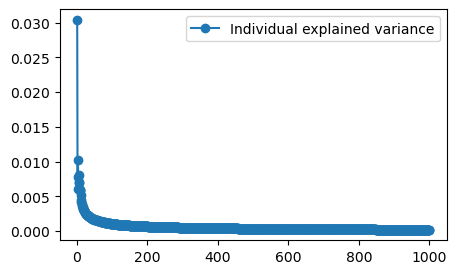

In [92]:
explained_variance = svd.explained_variance_ratio_
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', label='Individual explained variance')
plt.legend()

Variance explained by each component is abysmal.

## Model Performance with Dimension Reduction

### UMAP-Logistic Model

In [102]:
pipe_umap = Pipeline([
    ('lemmatizer', lemmatizer),
    ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
    ('umap', umap.UMAP(n_neighbors=2, min_dist=1, n_components=200, metric='cosine')),
    ('logreg', LogisticRegression(max_iter=5000, C=10))
], memory=memory)
pipe_umap.fit(text_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(memory=Memory(location=./cache/joblib),
         steps=[('lemmatizer',
                 FunctionTransformer(func=<function clean_and_lemmatize at 0x7fb455430220>)),
                ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
                ('umap',
                 UMAP(angular_rp_forest=True, metric='cosine', min_dist=1, n_components=200, n_neighbors=2, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('logreg', LogisticRegression(C=10, max_iter=5000))])

In [103]:
y_pred_umap = pipe_umap.predict(text_test)
print(f'f1 score for UMAP-Logistic model: {f1_score(y_pred_umap, y_test, average='micro'):.3f}')

f1 score for UMAP-Logistic model: 0.465


This approach is not working

### SVD-Logistic

In [110]:
pipe_svd = Pipeline([
    ('lemmatizer', lemmatizer),
    ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
    ('svd', TruncatedSVD(n_components=2000, n_iter=10, random_state=0)),
    ('logreg', LogisticRegression(max_iter=5000, C=10))
], memory=memory)
pipe_svd.fit(text_train, y_train)

Pipeline(memory=Memory(location=./cache/joblib),
         steps=[('lemmatizer',
                 FunctionTransformer(func=<function clean_and_lemmatize at 0x7fb455430220>)),
                ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
                ('svd',
                 TruncatedSVD(n_components=2000, n_iter=10, random_state=0)),
                ('logreg', LogisticRegression(C=10, max_iter=5000))])

In [111]:
y_pred_svd = pipe_svd.predict(text_test)
print(f'f1 score for Truncated_SVD-Logistic model: {f1_score(y_pred_svd, y_test, average='micro'):.3f}')

f1 score for Truncated_SVD-Logistic model: 0.807


With n_components=1000 for SVD, the model is giving 0.79 as the score for the test data, and with 2000 components it is giving 0.807.

# Prediction

## Models

v1.2.0

pipe = make_pipeline(TfidfVectorizer(min_df=2),
                     LogisticRegression(max_iter=1000, C=10))

Best score: 0.775

v1.4.0

Lemma + tfidf + Ridge

pipe = Pipeline([
    ('lemmatizer', lemmatizer),
    ('tfidf', TfidfVectorizer(min_df=best_params['tfidf__min_df'], ngram_range=best_params['tfidf__ngram_range'])),
    ('ridge', RidgeClassifier(max_iter=1000, alpha=best_params['ridge__alpha']))
], memory=memory)

Best parameters: {'ridge__alpha': 1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}

Best score: 0.771

Representation of X_train: 160894 stored elements and shape (7641, 16630)

v1.5.0

Lemma + tfidf + LogReg

Best parameters: {'logreg__C': 10, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 4)}

Best score: 0.775

Representation of X_train: 176328 stored elements and shape (7641, 33026)

## Final Model Training & Prediction

Pipeline training with best parameters

In [83]:
best_params = grid.best_params_
best_params

{'logreg__C': 10, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 4)}

In [112]:
pipe_pred = Pipeline([
    ('lemmatizer', lemmatizer),
    ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
    ('svd', TruncatedSVD(n_components=2000, n_iter=10, random_state=0)),
    ('logreg', LogisticRegression(max_iter=5000, C=10))
], memory=memory)
pipe_pred.fit(data['Question'], data['label'])

Pipeline(memory=Memory(location=./cache/joblib),
         steps=[('lemmatizer',
                 FunctionTransformer(func=<function clean_and_lemmatize at 0x7fb455430220>)),
                ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
                ('svd',
                 TruncatedSVD(n_components=2000, n_iter=10, random_state=0)),
                ('logreg', LogisticRegression(C=10, max_iter=5000))])

Prediction and submission file creation

In [115]:
submission_pred = pipe_pred.predict(test_data['Question'])
submission_df = pd.DataFrame({
    'id': test_data['id'],
    'label': submission_pred
})

In [116]:
submission_df.to_csv('submission/submission_v1.9.0.csv', index=False)